In [1]:
from commonfunctions import *
import cv2
inpath = '../inputs/'
outpath = '../outputs/segmentation/'

In [2]:
def integral_image(img):
    rows,cols = img.shape
    int_img = np.zeros(img.shape)
    int_img[0][0] = img[0][0]
    for r in range(1,rows):
        int_img[r][0] = int_img[r-1][0] + img[r][0]    
    for c in range(1,cols):
        int_img[0][c] = int_img[0][c-1] + img[0][c]  
    for r in range(1,rows):
        for c in range(1,cols):
            int_img[r][c] = img[r][c]+int_img[r][c-1] +int_img[r-1][c] - int_img[r-1][c-1] 
    return int_img

In [3]:
def Segment(img,window,t =10):
    rows,cols = img.shape
    output = np.zeros(img.shape, dtype="uint8")
    int_img = integral_image(img)
    s = int(window/2)
    p_img = np.pad(img,s,"constant")
    p_int = np.pad(int_img,s,'edge')
    for r in range(s+1,rows+s):
        for c in range(s+1,cols+s):
            x1 = c-s
            x2 = c+s
            y1 = r-s
            y2 = r+s
            count = (x2-x1)*(y2-y1)
            sum = p_int[y2,x2] - p_int[y2,x1-1] - p_int[y1-1,x2] + p_int[y1-1,x1-1]
            if(img[r-s][c-s]*count)<=(sum*(100-t)/100):
                output[r-s][c-s]=0
            else:
                output[r-s][c-s]=255
    return output        
                

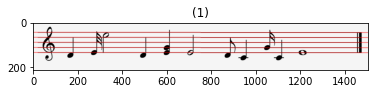

In [70]:
sheet = cv2.imread(inpath+"01.jpg")
sheet_t = Segment(cv2.cvtColor(sheet, cv2.COLOR_BGR2GRAY),11,33)

img = sheet.copy()  
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150)

minLineLength = (img.shape[1] * 2 // 3)
temp_lines = []
hough = cv2.HoughLines(edges,1,np.pi/180,minLineLength)
for rho,theta in hough[:,0,:]:
    if theta < 10:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + img.shape[1]*(-b))
        y1 = int(y0 + img.shape[1]*(a))
        x2 = int(x0 - img.shape[1]*(-b))
        y2 = int(y0 - img.shape[1]*(a))

        cv2.line(img,(x1,y1),(x2,y2),(255,0,0),1)
        temp_lines.append((rho, theta))
temp_lines.sort()
show_images([img])
# now we have lines

In [75]:
# remove repeated lines
lines = []
j = -1
for i in range(0, len(temp_lines)):
    if j < 0 or abs(lines[j][0] - temp_lines[i][0]) > 5 or abs(lines[j][1] - temp_lines[i][1]) > 2:
        lines.append(temp_lines[i])
        j += 1
remove
print(len(lines))

5


In [ ]:
sheet2 = io.imread(inpath+"02.png")
sheet_t2 = Segment(rgb2gray(sheet2),11,33)
io.imsave(outpath+'2.jpg',sheet_t2)